<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


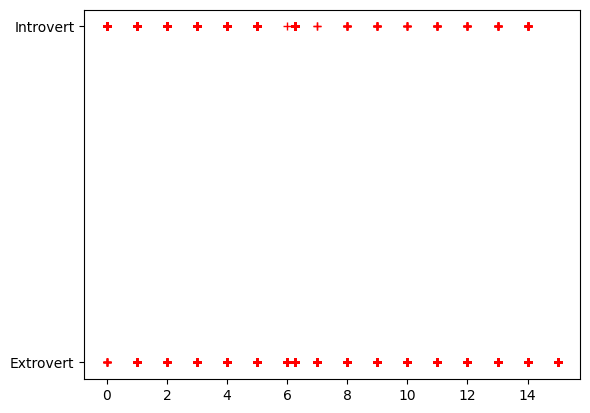

In [58]:
import pandas as pd     
import os
import numpy as np
import matplotlib.pyplot as plt


df=pd.read_csv('personality_datasert.csv')
df.head()
plt.plot(df['Friends_circle_size'], df['Personality'],'r+')
df.info()


In [59]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [60]:

from sklearn.model_selection import train_test_split

# Segregate features and target
y = df['Personality']
X = df.drop('Personality', axis=1)

# Split into train and test sets

In [61]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Copy the dataframe to avoid modifying the original
df_encoded = df.copy()

# Label encode the specified columns
le = LabelEncoder()
for col in ['Stage_fear', 'Drained_after_socializing', 'Personality']:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Separate features and target
X = df_encoded.drop('Personality', axis=1)
y = df_encoded['Personality']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Now split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')

Logistic Regression Accuracy: 0.9190
Random Forest Accuracy: 0.9207
SVC Accuracy: 0.9293
KNN Accuracy: 0.9259
Decision Tree Accuracy: 0.8741


In [71]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Accuracy
print('SVC Accuracy:', accuracy_score(y_test, y_pred))

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

SVC Accuracy: 0.9293103448275862
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580

Confusion Matrix:
[[278  24]
 [ 17 261]]


In [64]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_groq import ChatGroq       
from langgraph.checkpoint.memory import MemorySaver


In [65]:
@tool
def personality_predictor(
    Time_spent_Alone: float,
    Stage_fear: str,
    Social_event_attendance: float,
    Going_outside: float,
    Drained_after_socializing: str,
    Friends_circle_size: float,
    Post_frequency: float
) -> str:
    """Predicts if a person is an extrovert or introvert based on features."""
    # Encode categorical features
    stage_fear_encoded = 1 if Stage_fear.lower() == 'yes' else 0
    drained_encoded = 1 if Drained_after_socializing.lower() == 'yes' else 0
    # Arrange features in correct order
    X = np.array([[Time_spent_Alone, stage_fear_encoded, Social_event_attendance, Going_outside, drained_encoded, Friends_circle_size, Post_frequency]])
    # Standardize
    X_scaled = scaler.transform(X)
    # Predict
    pred = svc.predict(X_scaled)[0]
    # Map prediction to label
    return 'Extrovert' if pred == 1 else 'Introvert'

In [66]:
from langgraph.prebuilt import create_react_agent
load_dotenv()

memory = MemorySaver()
model = ChatGroq(model="llama-3.1-8b-instant")



prompt1="""You are a supervisor agent, the user will give values to another agent 
        you have 6 features and on that basis another agent will decide whether the user is
         extrovert or introvert. the features are:
        0   Time_spent_Alone           
        1   Stage_fear                 
        2   Social_event_attendance    
        3   Going_outside               
        4   Drained_after_socializing  
        5   Friends_circle_size        
        6   Post_frequency 
        stage fear is either yes or no, and drained after socializing is either yes or no
         if the information isnt sufficient, you can take random values as per your choice 
         , you standard scale all the values and pass it in the tool
          remember only make tool calls and if you cannot make it just say 'i dont know' """

supervisor_agent= create_react_agent(
    model=model,
    tools=[personality_predictor],
    prompt=prompt1,
)


In [67]:
graph = StateGraph(MessagesState)
graph.add_node("supervisor", supervisor_agent)
graph.set_entry_point("supervisor")
graph.add_edge("supervisor",END)
app=graph.compile()



In [68]:
user_input = "i spend 9 hours alone, i dont have a ny stage fear, dont attend any event, never go out, and have no friend circle"

events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    stream_mode="values",
)

# Print all messages to see tool calls
for event in events:
    print("=== EVENT ===")
    for i, msg in enumerate(event["messages"]):
        print(f"Message {i}:")
        print(f"  Type: {type(msg)}")
        print(f"  Content: {msg}")
        print(f"  Role: {getattr(msg, 'role', 'N/A')}")
        print(f"  Tool Call ID: {getattr(msg, 'tool_call_id', 'N/A')}")
        print("---")

=== EVENT ===
Message 0:
  Type: <class 'langchain_core.messages.human.HumanMessage'>
  Content: content='i spend 9 hours alone, i dont have a ny stage fear, dont attend any event, never go out, and have no friend circle' additional_kwargs={} response_metadata={} id='0a444910-5935-4ce2-95e4-1bca105122bf'
  Role: N/A
  Tool Call ID: N/A
---


c:\Users\Rinku\OneDrive\Desktop\Langgraph\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


=== EVENT ===
Message 0:
  Type: <class 'langchain_core.messages.human.HumanMessage'>
  Content: content='i spend 9 hours alone, i dont have a ny stage fear, dont attend any event, never go out, and have no friend circle' additional_kwargs={} response_metadata={} id='0a444910-5935-4ce2-95e4-1bca105122bf'
  Role: N/A
  Tool Call ID: N/A
---
Message 1:
  Type: <class 'langchain_core.messages.ai.AIMessage'>
  Content: content='' additional_kwargs={'tool_calls': [{'id': '0gwk0pexq', 'function': {'arguments': '{"Drained_after_socializing":"no","Friends_circle_size":0,"Going_outside":0,"Post_frequency":0,"Social_event_attendance":0,"Stage_fear":"no","Time_spent_Alone":9}', 'name': 'personality_predictor'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 526, 'total_tokens': 596, 'completion_time': 0.093333333, 'prompt_time': 0.038789409, 'queue_time': 0.049851591, 'total_time': 0.132122742}, 'model_name': 'llama-3.1-8b-instant', 'system_fing

In [72]:
# Test the tool directly using .invoke()
result = personality_predictor.invoke({
    "Time_spent_Alone": 9.0,
    "Stage_fear": "no",
    "Social_event_attendance": 0.0,
    "Going_outside": 0.0,
    "Drained_after_socializing": "yes",
    "Friends_circle_size": 0.0,
    "Post_frequency": 1.0
})
print("Direct tool test result:", result)

Direct tool test result: Extrovert


c:\Users\Rinku\OneDrive\Desktop\Langgraph\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [73]:
user_input = "i spend 9 hours alone, i dont have a ny stage fear, dont attend any event, never go out, and have no friend circle"

events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    stream_mode="values",
)

# Print all messages to see tool calls
for event in events:
    print("=== EVENT ===")
    for i, msg in enumerate(event["messages"]):
        print(f"Message {i}:")
        print(f"  Type: {type(msg)}")
        print(f"  Content: {msg}")
        print(f"  Role: {getattr(msg, 'role', 'N/A')}")
        print(f"  Tool Call ID: {getattr(msg, 'tool_call_id', 'N/A')}")
        print("---")

=== EVENT ===
Message 0:
  Type: <class 'langchain_core.messages.human.HumanMessage'>
  Content: content='i spend 9 hours alone, i dont have a ny stage fear, dont attend any event, never go out, and have no friend circle' additional_kwargs={} response_metadata={} id='7371afd7-b8b1-48d2-965d-7aa4509a5c27'
  Role: N/A
  Tool Call ID: N/A
---


c:\Users\Rinku\OneDrive\Desktop\Langgraph\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


=== EVENT ===
Message 0:
  Type: <class 'langchain_core.messages.human.HumanMessage'>
  Content: content='i spend 9 hours alone, i dont have a ny stage fear, dont attend any event, never go out, and have no friend circle' additional_kwargs={} response_metadata={} id='7371afd7-b8b1-48d2-965d-7aa4509a5c27'
  Role: N/A
  Tool Call ID: N/A
---
Message 1:
  Type: <class 'langchain_core.messages.ai.AIMessage'>
  Content: content='' additional_kwargs={'tool_calls': [{'id': '4bzhsdch6', 'function': {'arguments': '{"Drained_after_socializing":"no","Friends_circle_size":0,"Going_outside":0,"Post_frequency":0,"Social_event_attendance":0,"Stage_fear":"no","Time_spent_Alone":9}', 'name': 'personality_predictor'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 526, 'total_tokens': 590, 'completion_time': 0.085333333, 'prompt_time': 0.038917649, 'queue_time': 0.07734398, 'total_time': 0.124250982}, 'model_name': 'llama-3.1-8b-instant', 'system_finge

In [76]:
for event in events:
    for msg in event["messages"]:
        print(msg)
        # If you want to filter tool calls:
        if getattr(msg, "tool_call_id", None) or getattr(msg, "role", None) == "tool":
            print("TOOL CALL:", msg)
            
for event in events:
    for msg in event["messages"]:
        if msg.get("role") == "tool" or "tool_call_id" in msg:
            print("TOOL CALL:", msg)      

for event in events:
    for msg in event["messages"]:
        print(msg)